In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
from PIL import ImageFile

import os

import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import torch
import torch.optim as optim
import torch.nn as nn

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [14]:
train_df_path = 'trainLabels.csv'

TRAIN = r'train'
TRAIN_IMAGE_FOLDER = r'train_imagefolder'

In [15]:
train_df = pd.read_csv(train_df_path, header=0)
train_df.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [16]:
len(train_df), len(os.listdir(TRAIN))

(35126, 35126)

In [17]:
# def resave_images(train_path, train_path_imagefolder, train_dataset):
#     for label in train_dataset['level'].unique():
#         path = os.path.join(train_path_imagefolder, str(label))

#         if not os.path.exists(path):
#             os.makedirs(path)
        
#     for index, row in train_df.iterrows():
#         image_name, image_label = row

#         image = pil_image.open(path = os.path.join(train_path, image_name + '.jpeg'))
#         image.save(os.path.join(train_path_imagefolder, str(image_label), image_name + '.jpeg'))

# resave_images(TRAIN, TRAIN_IMAGE_FOLDER, train_df)

In [18]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_IMAGE_FOLDER, transform=transform)

def train_val_dataset(dataset, val_split=0.3):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

datasets = train_val_dataset(train_dataset)

print(len(datasets['train']))
print(len(datasets['val']))

dataloaders = {x: DataLoader(datasets[x], 8, shuffle=True, num_workers=2) for x in ['train','val']}

24588
10538


In [19]:
# Initializing model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

net = models.resnet18(pretrained=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 128)
net.to(device)

Computation device: cuda:0



c:\Users\mashp\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mashp\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
# Training

n_epochs = 10
valid_loss_min = np.Inf

val_loss, val_acc = [], []
train_loss, train_acc = [], []

total_step = len(dataloaders['train'])
for epoch in range(1, n_epochs + 1):

    running_loss, correct, total = 0.0, 0, 0
    print(f'Epoch {epoch}\n')

    for batch_idx, (data_, target_) in enumerate(dataloaders['train']):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_).to(device)

        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)

        if (batch_idx) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))

    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')

    batch_loss, total_t,  correct_t = 0, 0, 0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (dataloaders['val']):
            data_t, target_t = data_t.to(device), target_t.to(device)

            outputs_t = net(data_t).to(device)

            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()

            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)

        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(dataloaders['val']))

        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')

    net.train()

Epoch 1

Epoch [1/10], Step [0/3074], Loss: 4.6663
Epoch [1/10], Step [100/3074], Loss: 4.6298
Epoch [1/10], Step [200/3074], Loss: 5.0391
Epoch [1/10], Step [300/3074], Loss: 4.6114
Epoch [1/10], Step [400/3074], Loss: 4.6361
Epoch [1/10], Step [500/3074], Loss: 4.7344
Epoch [1/10], Step [600/3074], Loss: 4.5589
Epoch [1/10], Step [700/3074], Loss: 4.7779
Epoch [1/10], Step [800/3074], Loss: 4.1565
Epoch [1/10], Step [900/3074], Loss: 4.0672
Epoch [1/10], Step [1000/3074], Loss: 4.0193
Epoch [1/10], Step [1100/3074], Loss: 3.2947
Epoch [1/10], Step [1200/3074], Loss: 3.0394
Epoch [1/10], Step [1300/3074], Loss: 3.3026
Epoch [1/10], Step [1400/3074], Loss: 3.6958
Epoch [1/10], Step [1500/3074], Loss: 3.1893
Epoch [1/10], Step [1600/3074], Loss: 2.3205
Epoch [1/10], Step [1700/3074], Loss: 2.9703
Epoch [1/10], Step [1800/3074], Loss: 3.1952
Epoch [1/10], Step [1900/3074], Loss: 3.3853
Epoch [1/10], Step [2000/3074], Loss: 2.7842
Epoch [1/10], Step [2100/3074], Loss: 2.9512
Epoch [1/10],

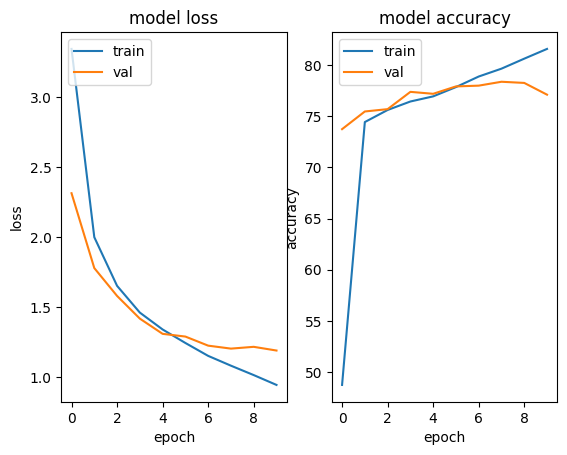

In [21]:
plt.subplot(1, 2, 1)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
res = pd.DataFrame(zip(train_acc, val_acc, train_loss, val_loss), columns = ['train_acc', 'val_acc', 'train_loss', 'val_loss'])
res

,train_acc,val_acc,train_loss,val_loss
0,48.743289,73.733156,3.344729,2.314138
1,74.426550,75.460239,2.000035,1.779406
2,75.605987,75.687986,1.652617,1.580541
3,76.435660,77.377111,1.461466,1.418405
4,76.935904,77.187322,1.341001,1.309716
5,77.842850,77.908522,1.244487,1.290284
6,78.875874,77.984437,1.152356,1.225434
7,79.644542,78.364016,1.082376,1.204273
8,80.620628,78.250142,1.015246,1.217023
9,81.572312,77.101917,0.944938,1.190559


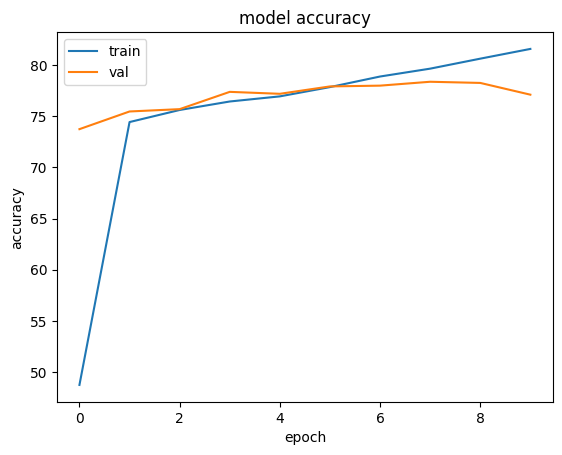

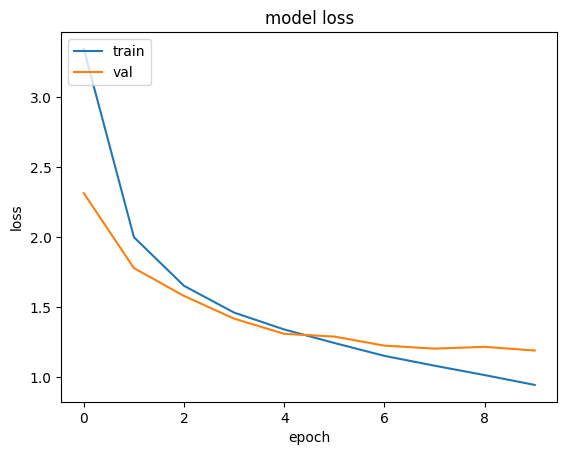

In [52]:
plt.plot(res[['train_acc', 'val_acc']])
plt.legend(['train', 'val'], loc='upper left')

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

plt.plot(res[['train_loss', 'val_loss']])
plt.legend(['train', 'val'], loc='upper left')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()